# DeepDTA notebook

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader

# load in the three datasets
data_Kd = DTI(name = 'BindingDB_Kd')
data_Kd.convert_to_log(form = 'binding')

data_ic50 = DTI(name = 'BindingDB_IC50')
data_ic50.convert_to_log(form = 'binding')

data_Ki = DTI(name = 'BindingDB_Ki')
data_Ki.convert_to_log(form = 'binding')

Downloading...
100%|████████████████████████████████████████████████████████████████████████████| 54.4M/54.4M [00:04<00:00, 12.9MiB/s]
Loading...
Done!
To log space...
Downloading...
100%|██████████████████████████████████████████████████████████████████████████████| 839M/839M [01:01<00:00, 13.7MiB/s]
Loading...
Done!
To log space...
Downloading...
100%|██████████████████████████████████████████████████████████████████████████████| 236M/236M [00:15<00:00, 15.7MiB/s]
Loading...
Done!
To log space...


## ALS model
Model used is adapted from https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74

In [2]:
def data_split(data):
    # split data and get ID dicts
    split = data.get_split(method = 'random', seed = 42, frac = [0.6, 0.05, 0.35])
    train = split['train']
    test = split['test']

    train = train[['Drug_ID', 'Target', 'Y']].dropna()

    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug_ID']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))

    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # load data into correct format
    data["Target_ID2"] = data["Target"].apply(lambda x:target_dict.get(x))
    data["Drug_ID2"] = data["Drug_ID"].apply(lambda x:drug_dict.get(x))
    data = data.dropna()

    drug_ID = data["Drug_ID2"].to_numpy()
    target_ID = data["Target_ID2"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label


class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)

In [3]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

In [4]:
def train_model(train_loader, test_loader, model, num_epochs=10):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            #predict and calculate loss for item factor and bias
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            if loss_item > 0:
                cum_loss += loss_item
            else:
                count -= 1

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                loss_item = loss.item()
                if loss_item > 0:
                    cum_loss += loss_item
                else:
                    count -= 1
                
        test_loss = cum_loss/count
        test_losses.append(test_loss)
        if epoch % 2 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses

In [5]:
def model(data, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors=n_factors)

    train_losses, test_losses = train_model(train_dataloader, test_dataloader, model, num_epochs)
    
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
    plt.savefig(img_name)
    plt.show()

## Kd Dataset

epoch:  0  avg training loss:  33.2759672638717  avg test loss:  28.06465677533831
epoch:  2  avg training loss:  24.08497165874311  avg test loss:  19.091746636799403
epoch:  4  avg training loss:  18.65926076803997  avg test loss:  13.924940538406371
epoch:  6  avg training loss:  15.31273664790354  avg test loss:  10.83237714767456
epoch:  8  avg training loss:  13.146699495376295  avg test loss:  8.905244616099766
epoch:  10  avg training loss:  11.68004565633786  avg test loss:  7.650640303747995
epoch:  12  avg training loss:  10.6277952907951  avg test loss:  6.796592601708004
epoch:  14  avg training loss:  9.84687403964389  avg test loss:  6.188443389960698
epoch:  16  avg training loss:  9.230649276903481  avg test loss:  5.7361635667937145
epoch:  18  avg training loss:  8.739146972158153  avg test loss:  5.385824169431414
epoch:  20  avg training loss:  8.322001232463084  avg test loss:  5.104181480407715
epoch:  22  avg training loss:  7.97172517077938  avg test loss:  4.8

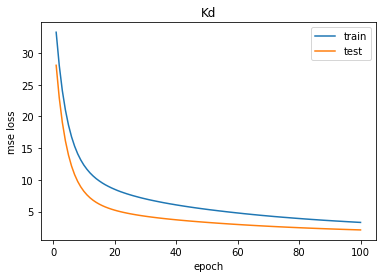

In [6]:
model(data_Kd, 'Kd', bs=100, num_epochs=100)

## IC50 Dataset

epoch:  0  avg training loss:  29.89830470526435  avg test loss:  20.639032198416537
epoch:  2  avg training loss:  13.962125431967017  avg test loss:  11.362727234511198
epoch:  4  avg training loss:  9.746925155949281  avg test loss:  8.264349045452349
epoch:  6  avg training loss:  7.708551521596004  avg test loss:  6.6910978372224195
epoch:  8  avg training loss:  6.488831546922393  avg test loss:  5.731207641774639
epoch:  10  avg training loss:  5.670982327844235  avg test loss:  5.0800171883686565
epoch:  12  avg training loss:  5.080789689763452  avg test loss:  4.607557813204702
epoch:  14  avg training loss:  4.634083145481355  avg test loss:  4.248180216474083
epoch:  16  avg training loss:  4.283596749053906  avg test loss:  3.9651818193591204
epoch:  18  avg training loss:  3.9998349510240807  avg test loss:  3.736021814866712
epoch:  20  avg training loss:  3.7664726978855194  avg test loss:  3.54693130442586
epoch:  22  avg training loss:  3.5694184185066296  avg test lo

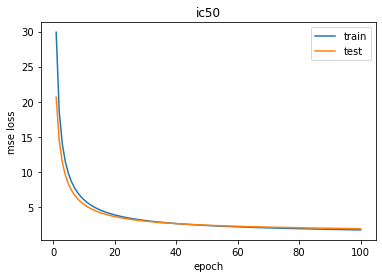

In [7]:
model(data_ic50, 'ic50', n_factors=20, bs=100, num_epochs=100)

## Ki Dataset

epoch:  0  avg training loss:  35.98181449042426  avg test loss:  24.996778645599324
epoch:  2  avg training loss:  18.13956129080933  avg test loss:  14.392521938225897
epoch:  4  avg training loss:  13.121375892324687  avg test loss:  10.726886044658407
epoch:  6  avg training loss:  10.587859504539052  avg test loss:  8.797983205044222
epoch:  8  avg training loss:  9.026463681438063  avg test loss:  7.59398698935812
epoch:  10  avg training loss:  7.954960704704339  avg test loss:  6.763792378654015
epoch:  12  avg training loss:  7.167560565856196  avg test loss:  6.152407049648817
epoch:  14  avg training loss:  6.5616668386912265  avg test loss:  5.680687733044966
epoch:  16  avg training loss:  6.079200833715419  avg test loss:  5.30328320747138
epoch:  18  avg training loss:  5.682887323975136  avg test loss:  4.993548232260512
epoch:  20  avg training loss:  5.351802944175659  avg test loss:  4.733796726544268
epoch:  22  avg training loss:  5.0690682601971435  avg test loss:

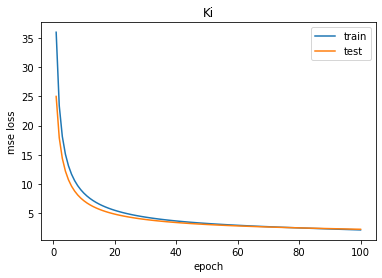

In [8]:
model(data_Ki, 'Ki', bs=100, num_epochs=100)